In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
from design import Design
from film import FilmSimple
from spectrum import Spectrum
import pickle


wls = np.linspace(400, 700, 20, dtype=float)
target_spec = Spectrum(0., wls, np.ones(wls.shape[0], dtype='float'))
init_d = np.array([1000], dtype='float')
init_film = FilmSimple('SiO2', 'TiO2', 'SiO2', init_d)
design = Design([target_spec], init_film)

design.TFNN_train(epoch=2, error=1e-10)
design.film.remove_negative_thickness_layer()
print(design.film.get_d())
d1_opt, d2_opt = design.film.get_d()[: 2]

search_range_d1 = np.linspace(0000, 400, 40)
search_range_d2 = np.linspace(0, 400, 40)
loss_arr = np.empty((search_range_d1.shape[0], search_range_d2.shape[0]))
for i, d1 in enumerate(search_range_d1):
    for j, d2 in enumerate(search_range_d2):
        d = design.film.get_d()
        d[0] = d1
        d[1] = d2
        design.film.update_d(d)
        loss_arr[i, j] = design.calculate_loss()
    

0-th iteration, loss: 0.7312457111462528, 41 gd steps
0-th iteration, new layer inserted. now 4 layers
[   0.         1021.44582356]


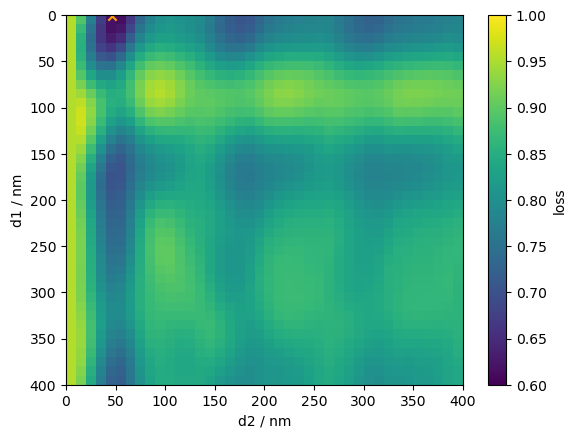

In [4]:
fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    (loss_arr),
    aspect = 'auto', 
    extent = [
        search_range_d2[0], 
        search_range_d2[-1], 
        search_range_d1[-1], 
        search_range_d1[0]
    ], 
    vmin = 0.6, 
    vmax = 1
)
ax.scatter(d2_opt, d1_opt, marker='x', color='orange')
ax.set_xlabel('d2 / nm')
ax.set_ylabel('d1 / nm')

cbar = fig.colorbar(s)
cbar.set_label('loss')


fig.savefig('./search_space_res/reflection_2layers_needle.png', dpi=500)

In [74]:
d = design.film.get_d()
d[0] = d1_opt
d[1] = d2_opt
design.film.update_d(d)
loss_0 = design.calculate_loss()

d = design.film.get_d()
d[0] = d1_opt + 1e-10
d[1] = d2_opt
design.film.update_d(d)
loss_1 = design.calculate_loss()

d = design.film.get_d()
d[0] = d1_opt
d[1] = d2_opt + 1e-10
design.film.update_d(d)
loss_2 = design.calculate_loss()


print((loss_1 ** 2- loss_0 ** 2) / 1e-10) 
print((loss_2 ** 2 - loss_0 ** 2) / 1e-10)

from gets.get_jacobi import get_jacobi_simple
J = np.empty((wls.shape[0] * 2, design.film.get_layer_number()))
get_jacobi_simple(
    J, 
    wls, 
    design.film.get_d(), 
    design.film.get_spec().n, 
    design.film.get_spec().n_sub, 
    design.film.get_spec().n_inc, 
    design.film.get_spec().INC_ANG
)
spec = np.hstack((design.film.get_spec().get_R(), design.film.get_spec().get_T()))
target_spec_arr = np.hstack((target_spec.get_R(), target_spec.get_T()))
print(spec.shape)
J.T @ (spec - target_spec_arr)

# BUG: note how LM exited optimization way before local minimum....

0.006659117701701689
0.005682121440031551
(40,)


array([6.66009199e-02, 5.68344610e-02, 1.17612046e-18])

0-th iteration, loss: 0.6045405833547226, 6 gd steps
0-th iteration, new layer inserted. now 3 layers
1-th iteration, loss: 0.3354200891875639, 31 gd steps
1-th iteration, new layer inserted. now 5 layers
2-th iteration, loss: 0.20066063368877524, 34 gd steps
2-th iteration, new layer inserted. now 7 layers
3-th iteration, loss: 0.060722636920388325, 54 gd steps
3-th iteration, new layer inserted. now 9 layers
[  0.          64.02585972  74.63093492  45.19914447 255.4822332
  68.65808391 523.58563173]


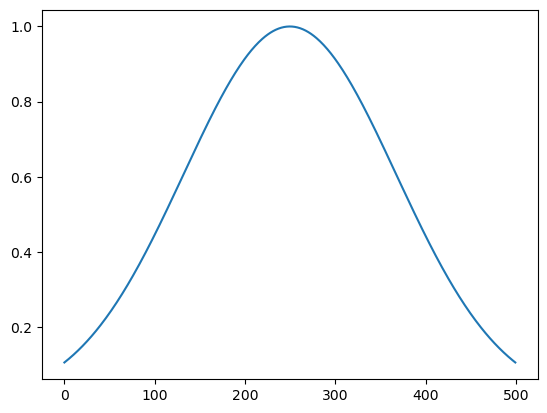

In [14]:
# different target?
wls = np.linspace(400, 700, 500)
target_spec = Spectrum(0, wls, np.exp(-((wls - 550) / 100) ** 2))
plt.plot(target_spec.get_R())
init_d = np.array([1000], dtype='float')
init_film = FilmSimple('SiO2', 'TiO2', 'SiO2', init_d)
design = Design([target_spec], init_film)

design.TFNN_train(epoch=4)
design.film.remove_negative_thickness_layer()
print(design.film.get_d())
d1_opt, d2_opt = design.film.get_d()[: 2]

search_range_d1 = np.linspace(0000, 400, 40)
search_range_d2 = np.linspace(0, 400, 40)
loss_arr = np.empty((search_range_d1.shape[0], search_range_d2.shape[0]))
for i, d1 in enumerate(search_range_d1):
    for j, d2 in enumerate(search_range_d2):
        d = design.film.get_d()
        d[0] = d1
        d[1] = d2
        design.film.update_d(d)
        loss_arr[i, j] = design.calculate_loss()

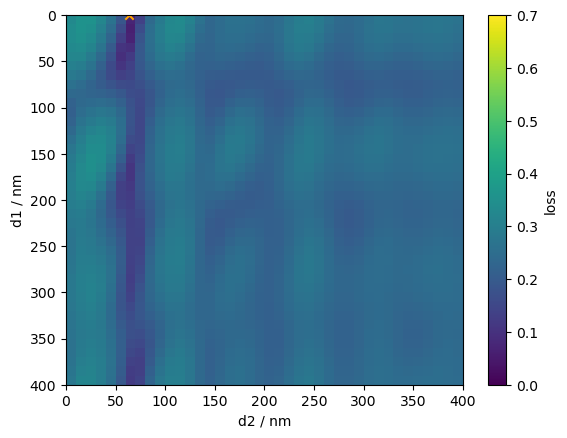

In [15]:
fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    (loss_arr),
    aspect = 'auto', 
    extent = [
        search_range_d2[0], 
        search_range_d2[-1], 
        search_range_d1[-1], 
        search_range_d1[0]
    ], 
    vmin = 0.0, 
    vmax = 0.7
)
ax.scatter(d2_opt, d1_opt, marker='x', color='orange')
ax.set_xlabel('d2 / nm')
ax.set_ylabel('d1 / nm')

cbar = fig.colorbar(s)
cbar.set_label('loss')


fig.savefig('./search_space_res/gaussian_4layers_tmp.png', dpi=500)